<a href="https://colab.research.google.com/github/Barryjuait/Barryjuait/blob/master/SAM_Organoids.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://youtu.be/83tnWs_YBRQ

**This notebook walks you through the process of fine-tuning a Segment Anything Model (SAM) using custom data**.
<p>

**What is SAM?**
<br>
SAM is an image segmentation model developed by Meta AI. It was trained over 11 billion segmentation masks from millions of images. It is designed to take human prompts, in the form of points, bounding boxes or even a text prompt describing what should be segmented.
<p>

**What are the key features of SAM?**
<br>

* **Zero-shot generalization:** SAM can be used to segment objects that it has never seen before, without the need for additional training.

* **Flexible prompting:** SAM can be prompted with a variety of input, including points, boxes, and text descriptions.

* **Real-time mask computation:** SAM can generate masks for objects in real time. This makes SAM ideal for applications where it is necessary to segment objects quickly, such as autonomous driving and robotics.

* **Ambiguity awareness:** SAM is aware of the ambiguity of objects in images. This means that SAM can generate masks for objects even when they are partially occluded or overlapping with other objects.

<p>

**How does SAM work?**
<br>
SAM works by first encoding the image into a high-dimensional vector representation. The prompt is encoded into a separate vector representation. The two vector representations are then combined and passed to a mask decoder, which outputs a mask for the object specified by the prompt.
<p>
The image encoder is a vision transformer (ViT-H) model, which is a large language model that has been pre-trained on a massive dataset of images. The prompt encoder is a simple text encoder that converts the input prompt into a vector representation. The mask decoder is a lightweight transformer model that predicts the object mask from the image and prompt embeddings.
<p>

**SAM paper:** https://arxiv.org/pdf/2304.02643.pdf​
<p>

**Link to the dataset used in this demonstration:** https://www.epfl.ch/labs/cvlab/data/data-em/
<br>Courtesy: EPFL
<p>

This code has been heavily adapted from this notebook but modified to work with a truly custom dataset where we have a bunch of images and binary masks.
https://github.com/NielsRogge/Transformers-Tutorials/blob/master/SAM/Fine_tune_SAM_(segment_anything)_on_a_custom_dataset.ipynb



In [ ]:
# Install the required libraries
#SAM
!pip install git+https://github.com/facebookresearch/segment-anything.git
#Transformers
!pip install -q git+https://github.com/huggingface/transformers.git
#Datasets to prepare data and monai if you want to use special loss functions
!pip install datasets
!pip install -q monai
#Patchify to divide large images into smaller patches for training. (Not necessary for smaller images)
!pip install patchify

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-08j5jros
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-08j5jros
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36590 sha256=4062aceb3d05005af494cfe4bb74297d1bd83949d6ca5a07425a755866413769
  Stored in directory: /tmp/pip-ephem-wheel-cache-bt4u_chj/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tifffile
import os
import random
import cv2

from PIL import Image
from scipy import ndimage
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from patchify import patchify  #Only to handle large images


Load data into numpy arrays. Here we are importing a tiff stack containing 165 images of size 768x1024. You can use glob to import multiple images from a directory or any other method. The goal is to end up with a numpy array for images and an array for masks.

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
homeFolder = '/content/drive/MyDrive/Colab Notebooks/Organoids/Processed/'
pic_folder = homeFolder + 'Annotated/images/'
png_folder = homeFolder + 'Annotated/brush_png/'
np_folder = homeFolder + 'Annotated/brush_numpy/'

In [ ]:
#import info from csv:
df = pd.read_csv(homeFolder + 'Annotated/brush_png.csv')
df.head(3)

annotation_id  annotator                   created_at  id  \
0              1          1  2023-11-20T20:06:15.383033Z   1   
1             28          1  2023-11-21T20:45:54.927499Z   2   
2             29          1  2023-11-21T20:52:05.406134Z   3   

                                               image  lead_time  \
0  /data/upload/3/d4c34e28-post_MLT19_P7_Amu_0.1_...   1676.785   
1  /data/upload/3/fefb6291-post_MLT19_P7_Amu_0.01...    467.461   
2  /data/upload/3/a05f7bb1-post_MLT19_P7_Amu_0.1_...    617.043   

                                                 tag  \
0  [{"format":"rle","rle":[0,87,239,160,57,27,255...   
1  [{"format":"rle","rle":[0,87,239,160,57,27,255...   
2  [{"format":"rle","rle":[0,87,239,160,57,27,255...   

                    updated_at  
0  2023-11-25T16:56:53.132065Z  
1  2023-11-25T16:56:30.529744Z  
2  2023-11-25T16:57:55.552915Z

In [ ]:
# Load tiff stack images and masks
idx = random.randint(0, len(df)-1)
fname = df.image[idx].split('-')
mname = f'task-{df.id[idx]}-annotation-{df.annotation_id[idx]}-by-1-tag-Organoid-0.png'

#165 large images as tiff image stack
list_img = os.listdir(pic_folder)
large_mask = plt.imread(png_folder + mname)
large_image = plt.imread(pic_folder + fname[1])


In [ ]:
large_image.shape

(1038, 1388)

Now. let us divide these large images into smaller patches for training. We can use patchify or write custom code.

In [ ]:
#Desired patch size for smaller images and step size.
patch_size = 256
step = 256

In [ ]:
def fillholes(img):# find the mask
  curr_mask = np.where(img>0, 1, img)
  curr_mask = curr_mask.astype(int)
  #img_gray = cv2.cvtColor(curr_mask, cv2.COLOR_BGR2GRAY)
  des = cv2.bitwise_not(~curr_mask)
  contour,hier = cv2.findContours(des,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)

  for cnt in contour:
      cv2.drawContours(des,[cnt],0,255,-1)

  result = cv2.bitwise_not(des)
  return ~result


In [ ]:
import numpy as np
import cv2

def fill_holes(img, iterations=1):
    # Convert mask to binary (0 or 255)
    _, binary_mask = cv2.threshold(img, 1, 255, cv2.THRESH_BINARY)

    # Use morphological closing to fill holes
    kernel = np.ones((5, 5), np.uint8)
    closed_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel, iterations=iterations)

    return closed_mask

# Example usage
#input_mask = cv2.imread('/path/to/mask_image.jpg', cv2.IMREAD_GRAYSCALE)
#filled_mask = fill_holes(input_mask, iterations=3)  # Adjust the number of iterations as needed

# Optionally, visualize or process the filled mask


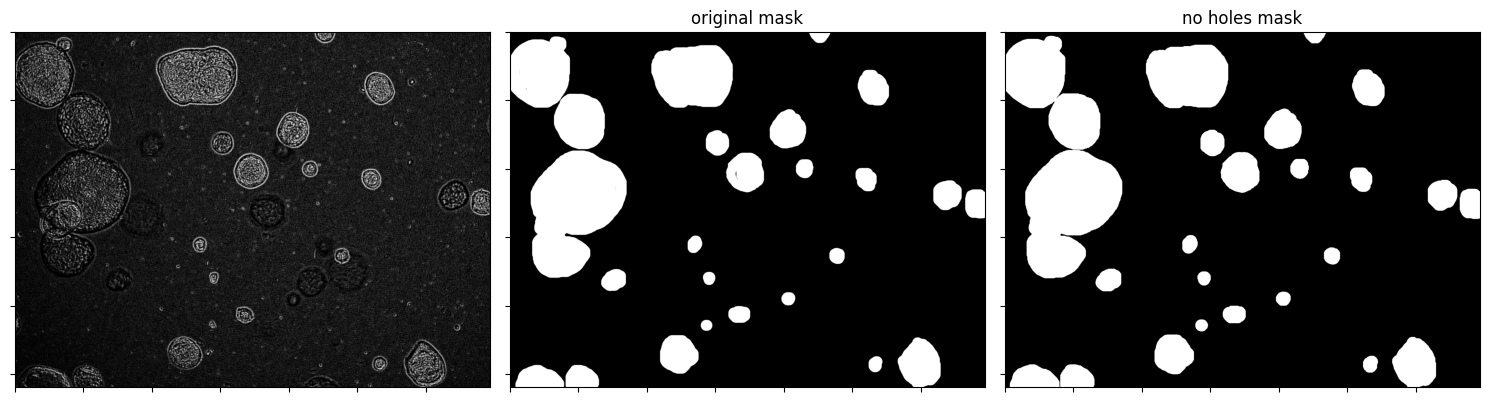

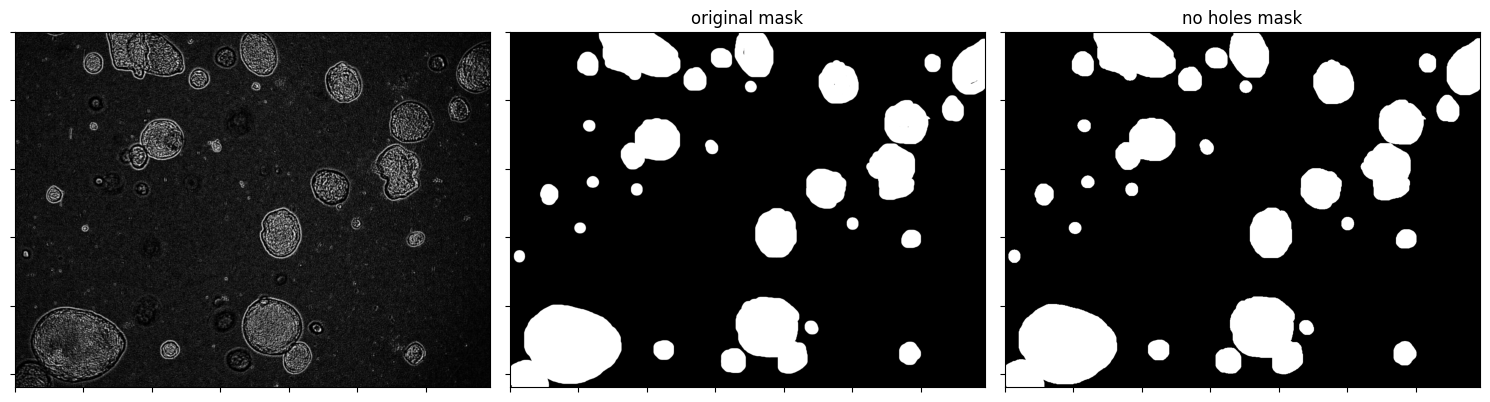

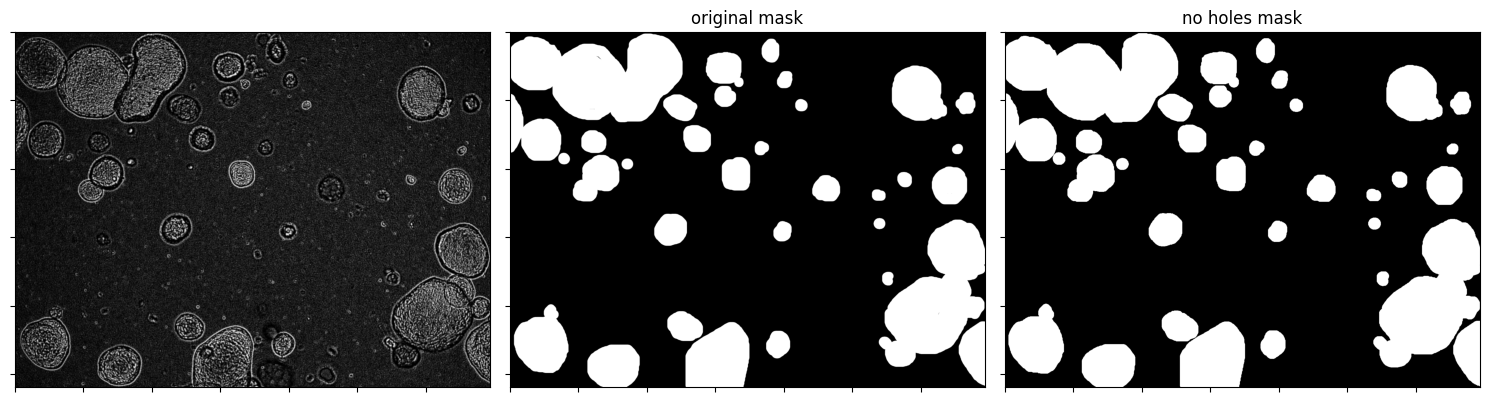

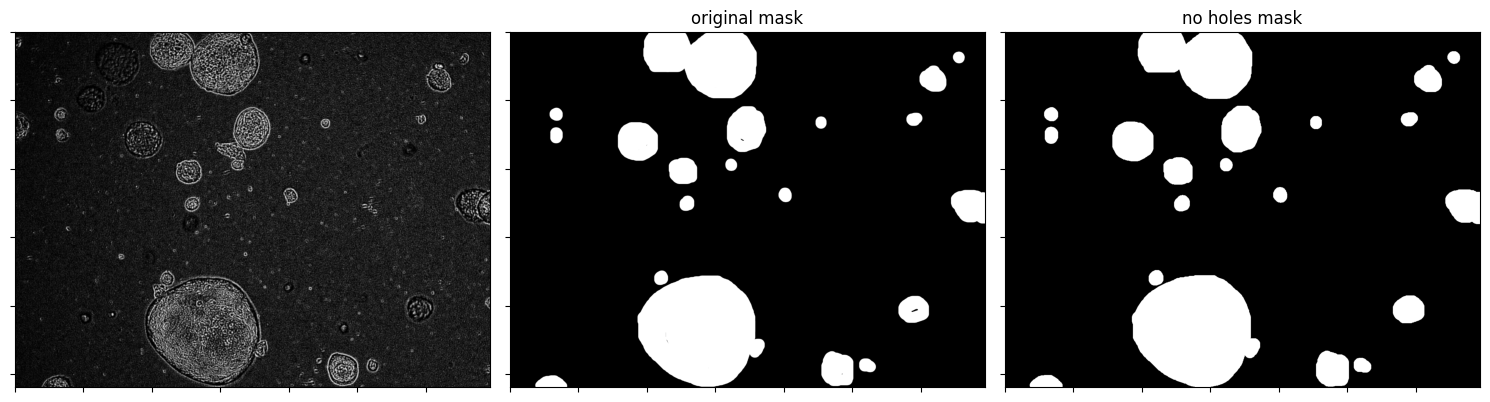

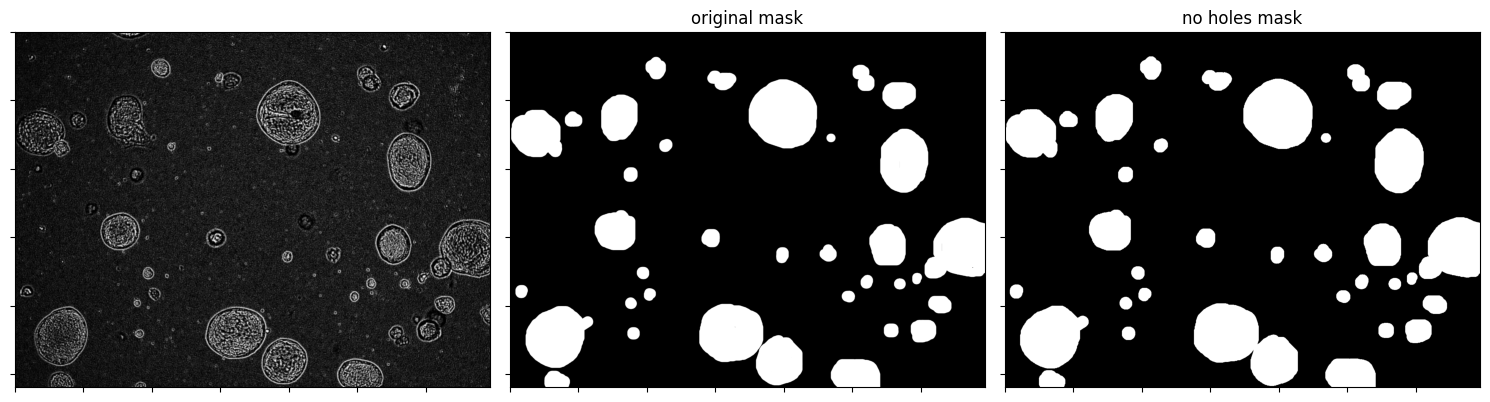

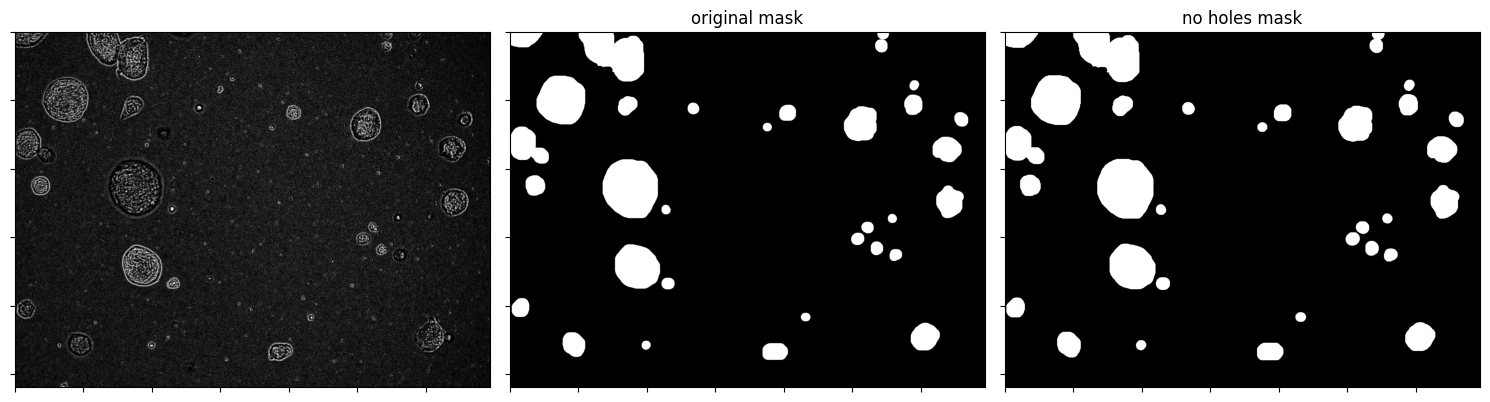

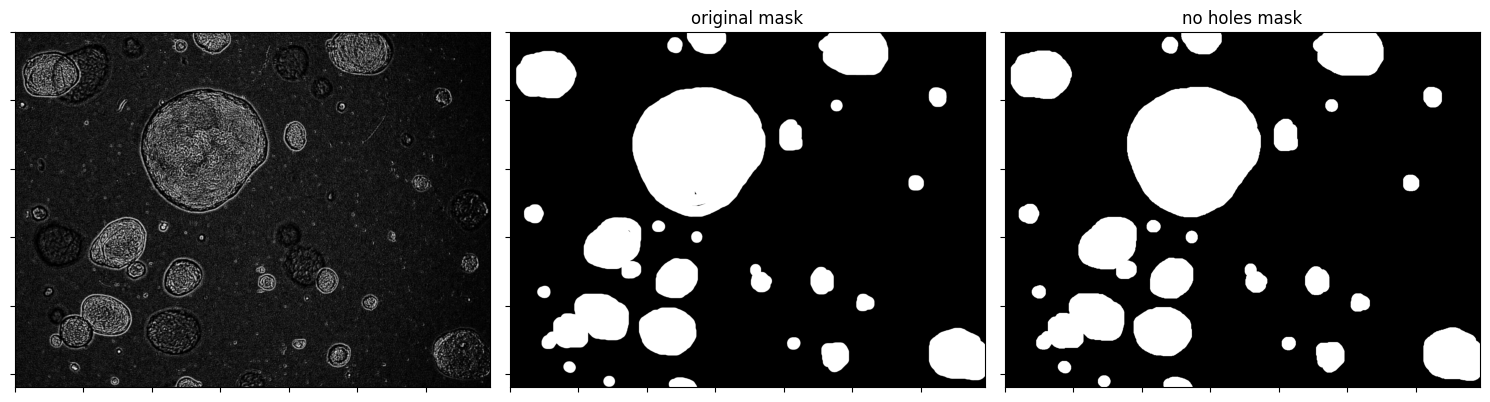

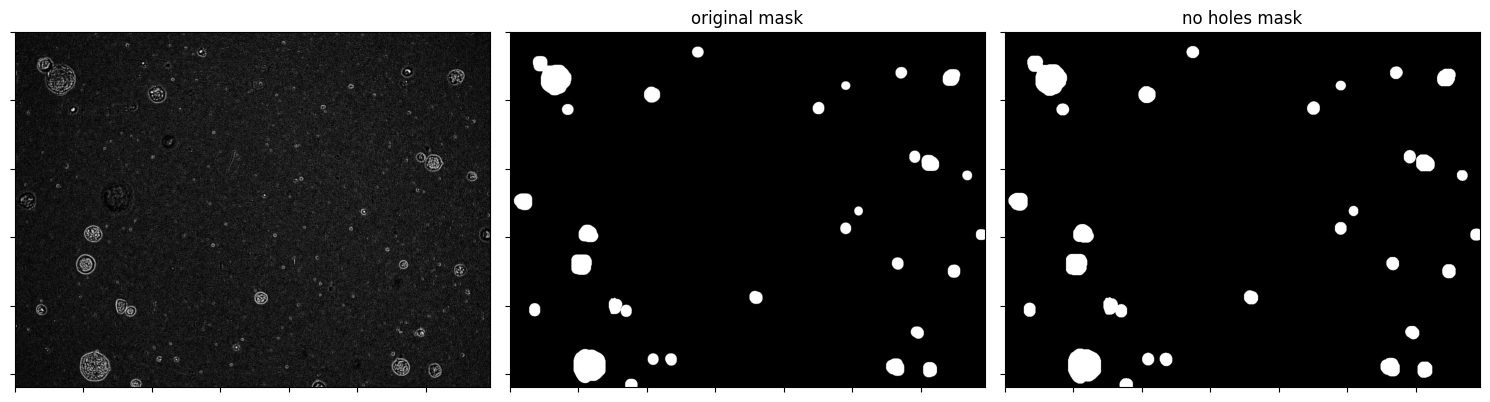

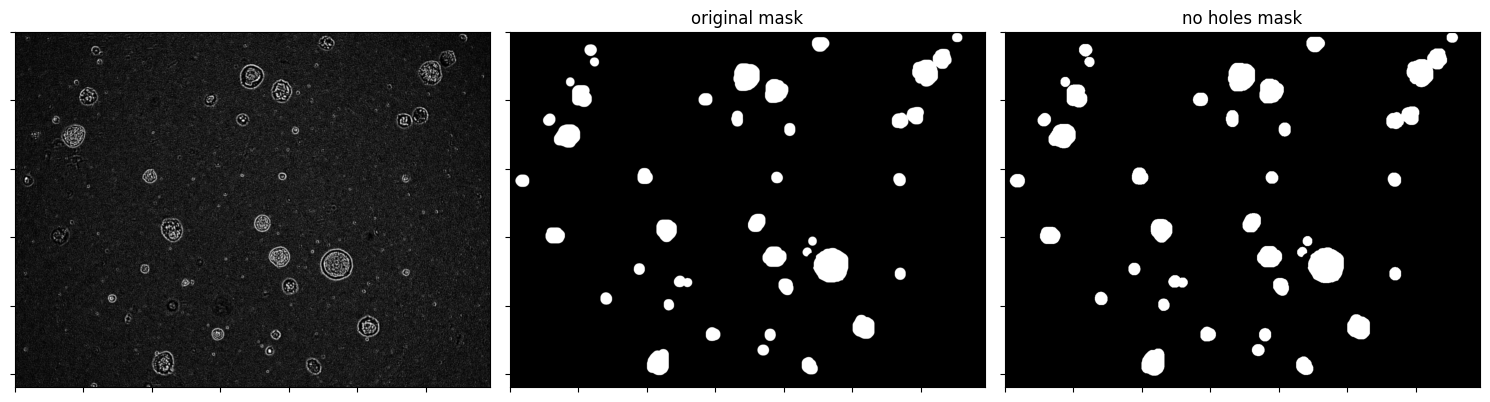

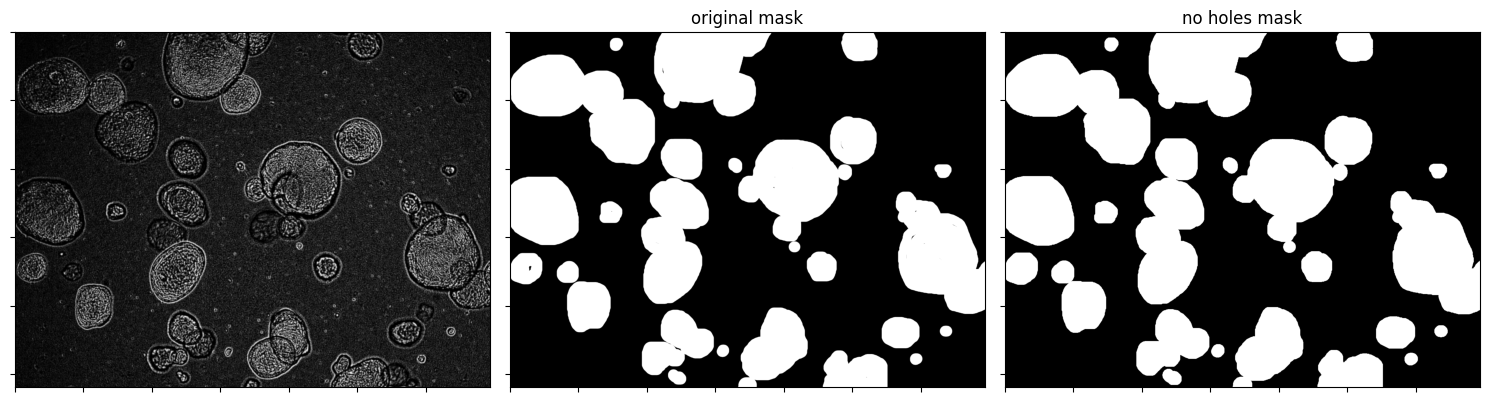

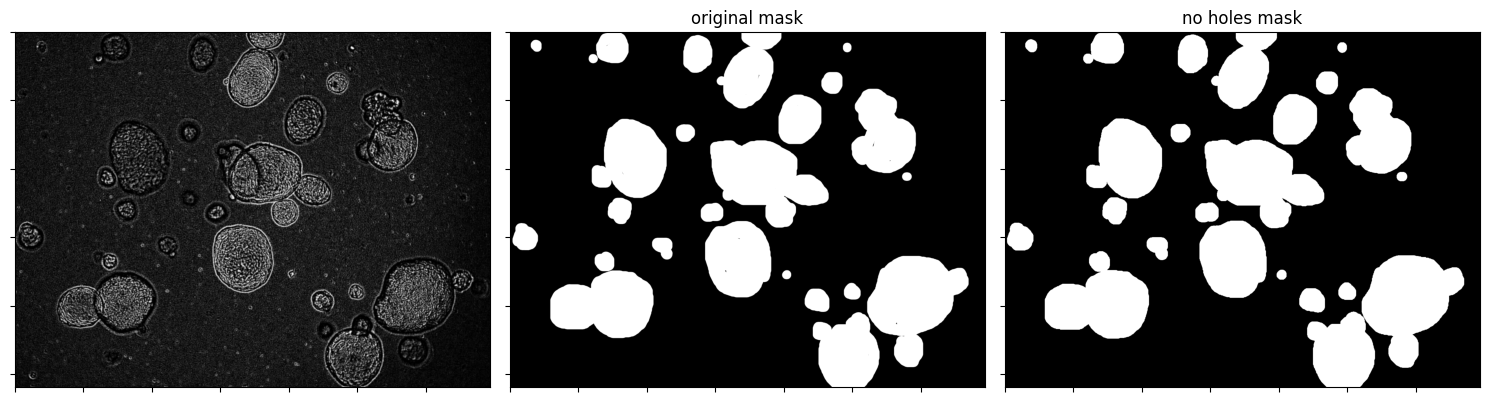

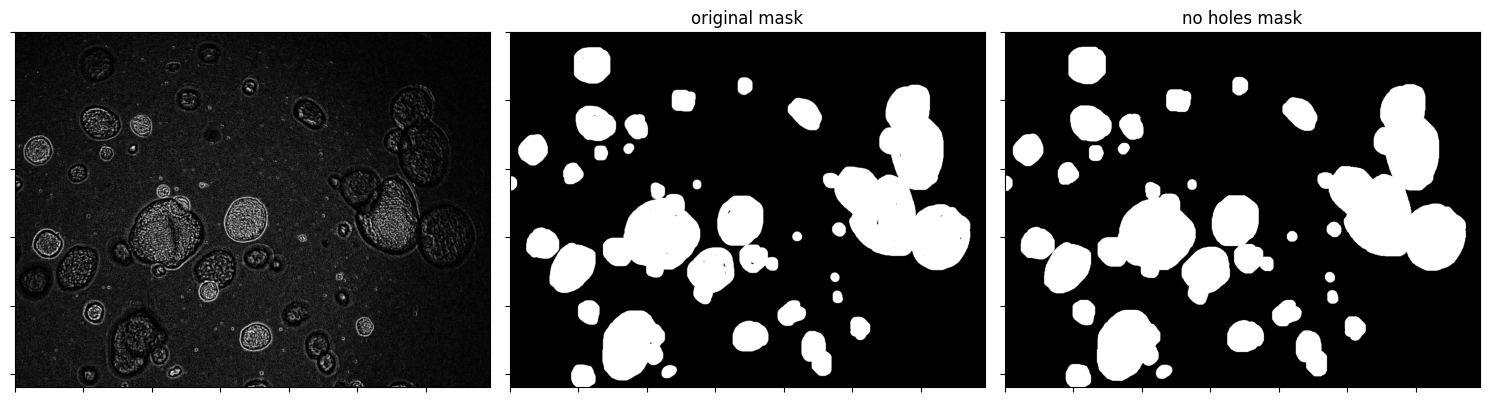

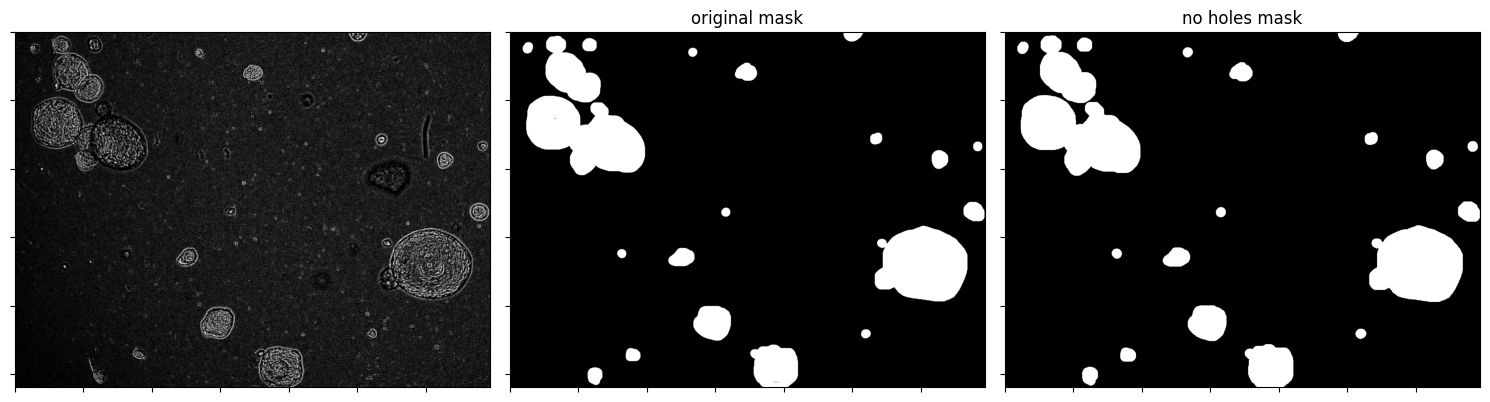

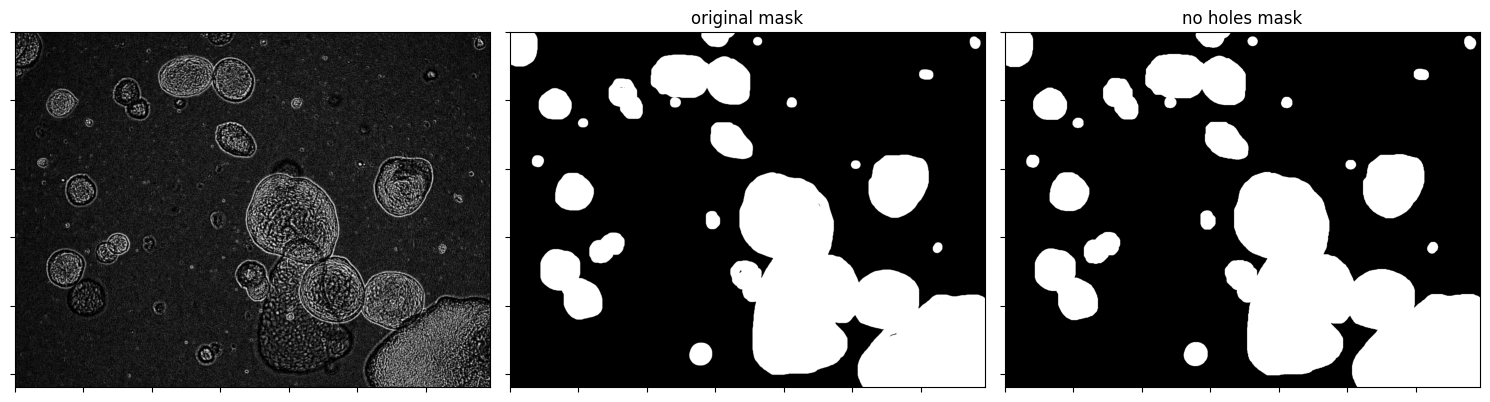

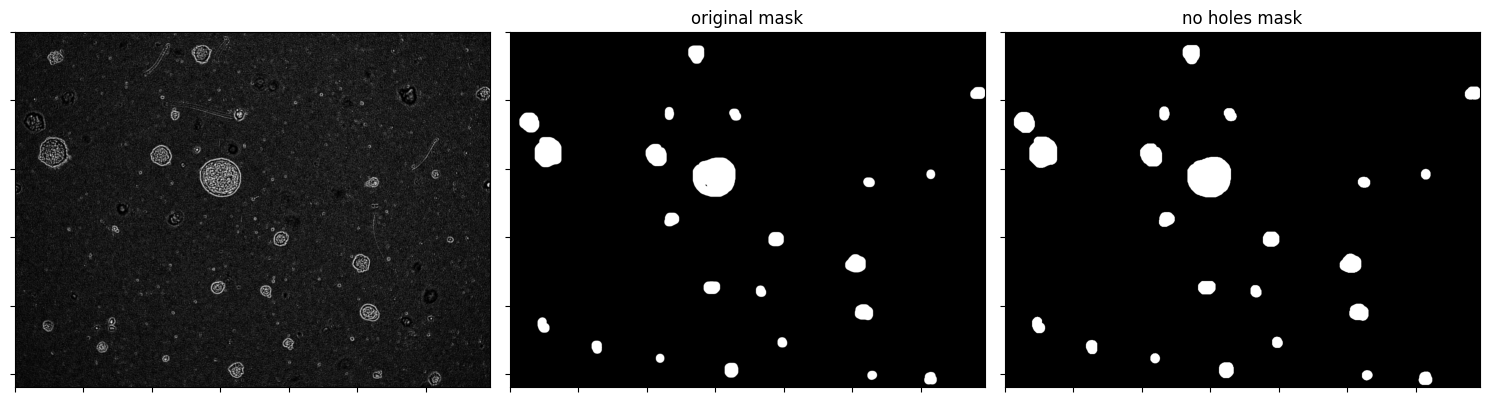

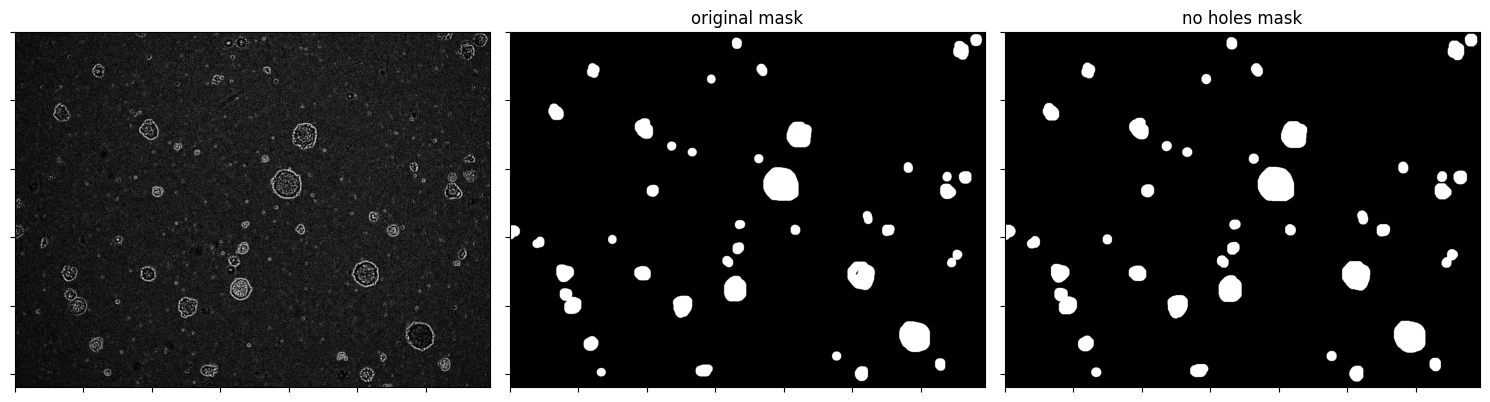

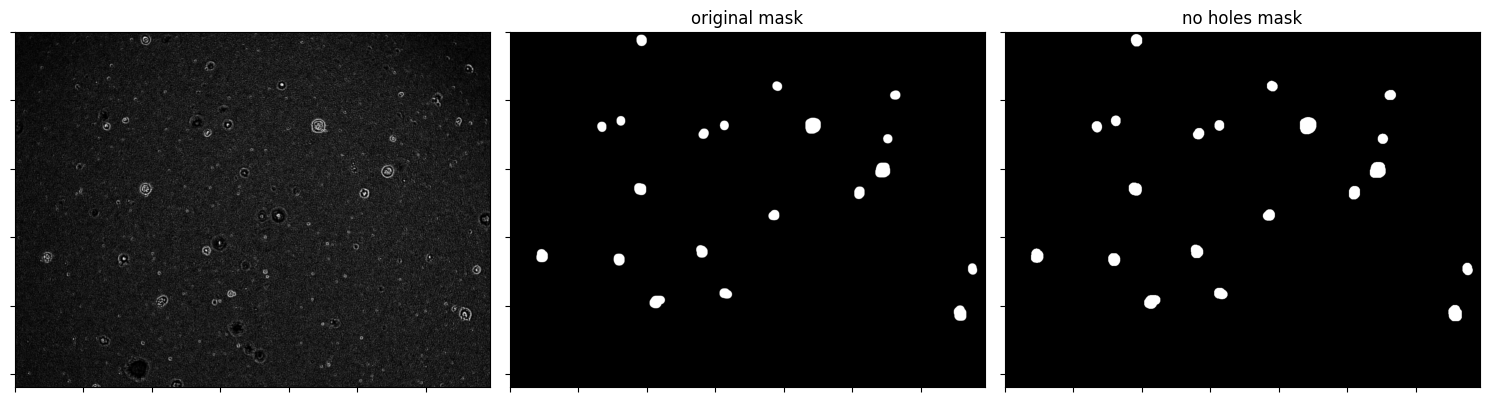

In [ ]:
bimg = []
bmask = []
plotFlag = True

for idx in range(len(df)):
#idx = random.randint(0, df.shape[0]-1)

  fname = df.image[idx].split('-')
  mname = f'task-{df.id[idx]}-annotation-{df.annotation_id[idx]}-by-1-tag-Organoid-0.png'

  mask = plt.imread(png_folder + mname)
  img = plt.imread(pic_folder + fname[1])

  #fill up holes
  new_mask  = fillholes(mask)

  #for debugging
  if plotFlag:
    fig, ax = plt.subplots(1,3, figsize = (15,6))
    ax[0].imshow(img, cmap = 'gray')
    ax[1].imshow(mask, cmap = 'gray')
    ax[1].set_title('original mask')
    ax[2].imshow(new_mask, cmap = 'gray')
    ax[2].set_title('no holes mask')
    for k in range(3):
      ax[k].set_xticklabels([])
      ax[k].set_yticklabels([])

    plt.tight_layout()
    plt.show()


  patches_img = patchify(img, (patch_size, patch_size), step=step)  #Step=256 for 256 patches means no overlap
  patches_mask = patchify(new_mask, (patch_size, patch_size), step=step)  #Step=256 for 256 patches means no overlap

  for i in range(patches_mask.shape[0]):
      for j in range(patches_mask.shape[1]):
        curr_img = (patches_img[i,j,:,:])
        curr_mask = (patches_mask[i,j,:,:])
        curr_mask = np.where(curr_mask>0, 1, curr_mask)


        bimg.append(curr_img)
        bmask.append(curr_mask)

bimg = np.array(bimg)
bmask = np.array(bmask)


In [ ]:
bmask.shape

(340, 256, 256)

Now, let us delete empty masks as they may cause issues later on during training. If a batch contains empty masks then the loss function will throw an error as it may not know how to handle empty tensors.

In [ ]:
# Create a list to store the indices of non-empty masks
valid_indices = [i for i, mask in enumerate(bmask) if mask.max() != 0]

# Filter the image and mask arrays to keep only the non-empty pairs
filtered_images = bimg[valid_indices]
filtered_masks = bmask[valid_indices]

print("Image shape:", filtered_images.shape)  # e.g., (num_frames, height, width, num_channels)
print("Mask shape:", filtered_masks.shape)

Image shape: (314, 256, 256)
Mask shape: (314, 256, 256)


Let us create a 'dataset' that serves us input images and masks for the rest of our journey.

In [ ]:
from datasets import Dataset
from PIL import Image

# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in filtered_images],
    "label": filtered_masks,  # Assuming filtered_masks are convertible to a list
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)

Let us make sure out images and masks (labels) are loading appropriately

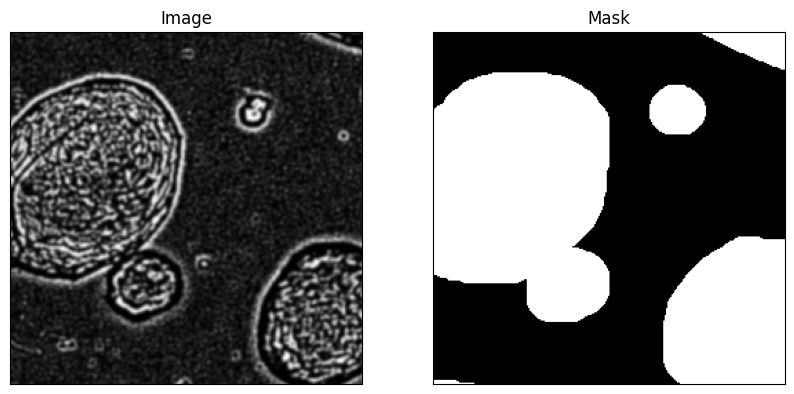

In [ ]:
img_num = random.randint(0, filtered_images.shape[0]-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

Get bounding boxes from masks. You can get here directly if you are working with coco style annotations where bounding boxes are captured in a JSON file.

In [ ]:
#Get bounding boxes from mask.
def get_bounding_box(ground_truth_map):
  if len(ground_truth_map) > 1:
    # get bounding box from mask
    y_indices, x_indices = np.where(ground_truth_map > 0)
    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)
    # add perturbation to bounding box coordinates
    H, W = ground_truth_map.shape
    x_min = max(0, x_min - np.random.randint(0, 20))
    x_max = min(W, x_max + np.random.randint(0, 20))
    y_min = max(0, y_min - np.random.randint(0, 20))
    y_max = min(H, y_max + np.random.randint(0, 20))

    bbox = [x_min, y_min, x_max, y_max]

  else:
    bbox = [0, 0, 256, 256]

  return bbox

In [ ]:
from torch.utils.data import Dataset
from PIL import Image

class SAMDataset(Dataset):
  """
  This class is used to create a dataset that serves input images and masks.
  It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
  """
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = np.array(item["image"])
    image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    ground_truth_mask = np.array(item["label"])

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image_rgb, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [ ]:
# Initialize the processor
from transformers import SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

In [ ]:
# Create an instance of the SAMDataset
train_dataset = SAMDataset(dataset=dataset, processor=processor)

In [ ]:
example = train_dataset[0]
for k,v in example.items():
  print(k,v.shape)


It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (256, 256)


In [ ]:
# Create a DataLoader instance for the training dataset
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=False)

In [ ]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 256, 256])


In [ ]:
batch["ground_truth_mask"].shape

torch.Size([2, 256, 256])

In [ ]:
# Load the model
from transformers import SamModel
model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder"):
    param.requires_grad_(False)

for name, param in model.named_parameters():
  if name.startswith("prompt_encoder"):
    param.requires_grad_(False)

config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/375M [00:00<?, ?B/s]

In [ ]:
from segment_anything.utils.transforms import ResizeLongestSide
import torch
from torch.optim import Adam
import monai
# Initialize the optimizer and the loss function
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
#Try DiceFocalLoss, FocalLoss, DiceCELoss
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')
loss_fn = torch.nn.MSELoss()


In [ ]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize
from segment_anything.utils.transforms import ResizeLongestSide
from torch.optim import Adam
import monai

# Initialize the optimizer and the loss function
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
#Try DiceFocalLoss, FocalLoss, DiceCELoss
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')
loss_fn = torch.nn.MSELoss()


retrainFlag = False

#Training loop #100 is a good number
num_epochs = 50

if torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"
print(f'device available: {device}')

if retrainFlag == True:
  model.to(device)

  model.train()
  all_losses = []  # List to store losses for each epoch

  for epoch in range(num_epochs):
      epoch_losses = []
      for batch in tqdm(train_dataloader):

        # forward pass
        outputs = model(pixel_values=batch["pixel_values"].to(device),
                        input_boxes=batch["input_boxes"].to(device),
                        multimask_output=False)

        #with torch.no_grad():
        # compute loss
        predicted_masks = outputs.pred_masks.squeeze(1)
        ground_truth_masks = batch["ground_truth_mask"].float().to(device)
        loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

        # backward pass (compute gradients of parameters w.r.t. loss)
        optimizer.zero_grad()
        loss.backward()

        # optimize
        optimizer.step()
        epoch_losses.append(loss.item())

      mean_loss = mean(epoch_losses);
      print(f'EPOCH: {epoch + 1}/{num_epochs}, Mean loss: {mean_loss}')
      all_losses.append(mean_loss)
      # Save the model's state dictionary to a file
      model_path = homeFolder + f'Annotated/SAM/orgModel_{epoch}.pth'
      torch.save(model.state_dict(), model_path)
      print(f'--- Model saved at: {model_path}')

  # Plot the loss over epochs
  plt.plot(range(1, num_epochs + 1), all_losses, marker='o')
  plt.title('Training Loss Over Epochs')
  plt.xlabel('Epochs')
  plt.ylabel('Mean Loss')
  plt.show()



**Inference**

In [ ]:
from transformers import SamModel, SamConfig, SamProcessor
import torch


epoch = 43
model_path = homeFolder + f'Annotated/SAM/orgModel_{epoch-1}.pth'

# Load the model configuration
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Create an instance of the model architecture with the loaded configuration
bModel = SamModel(config=model_config)
#Update the model by loading the weights from saved file.
bModel.load_state_dict(torch.load(model_path))
# set the device to cuda if available, otherwise use cpu
bModel.to(device)
print('ready to go')

ready to go


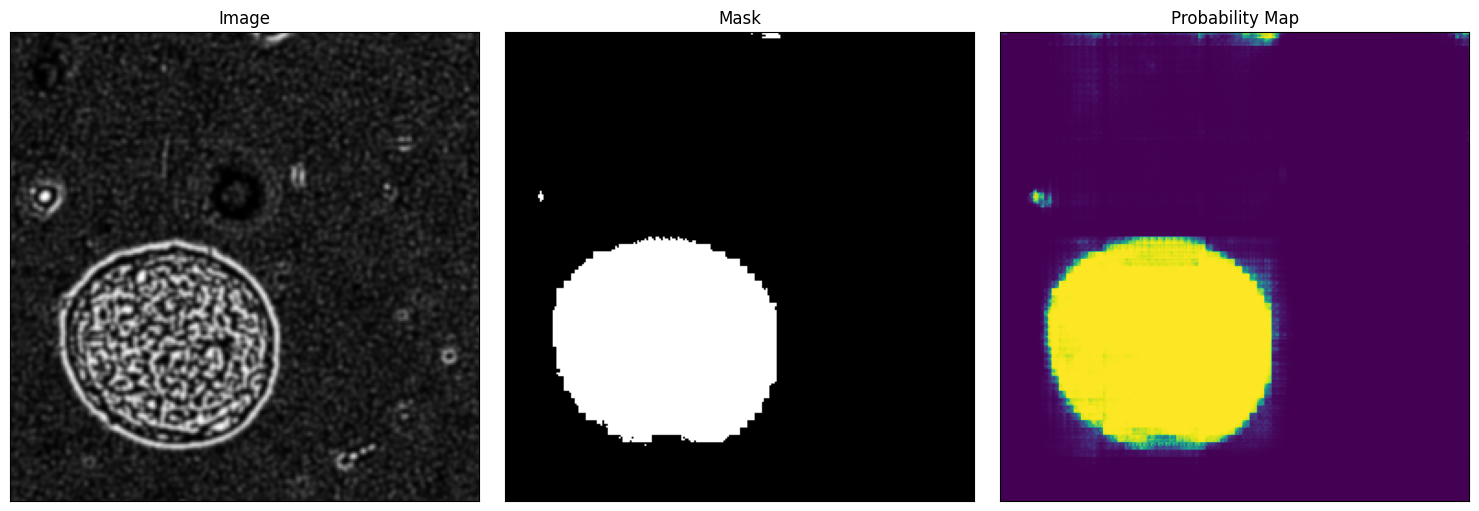

In [ ]:
import numpy as np
import random
import torch
import matplotlib.pyplot as plt

# let's take a random training example
idx = random.randint(0, filtered_images.shape[0]-1)

# load image
test_image = np.array(dataset[idx]["image"])
image_rgb = cv2.cvtColor(test_image, cv2.COLOR_GRAY2RGB)

# get box prompt based on ground truth segmentation map
ground_truth_mask = np.array(dataset[idx]["label"])
prompt = get_bounding_box(ground_truth_mask)

# prepare image + box prompt for the model
inputs = processor(image_rgb, input_boxes=[[prompt]], return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}

bModel.eval()

# forward pass
with torch.no_grad():
  #print('yes')
  outputs = bModel(**inputs, multimask_output=False)

# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.8).astype(np.uint8)


fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first image on the left
axes[0].imshow(np.array(test_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(medsam_seg, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Plot the second image on the right
axes[2].imshow(medsam_seg_prob)  # Assuming the second image is grayscale
axes[2].set_title("Probability Map")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.tight_layout()


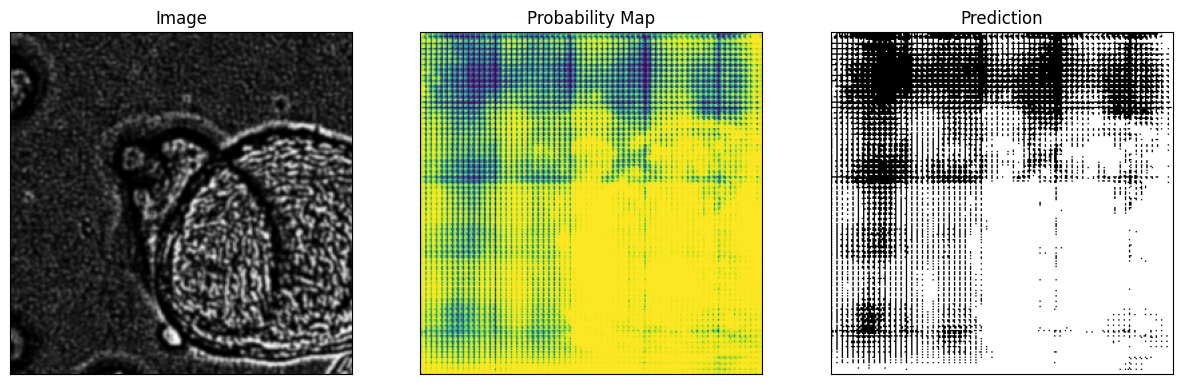

In [ ]:
#Apply a trained model on a large, unknown image
idx = random.randint(0, len(df)-1)
fname = df.image[idx].split('-')
large_test_image = plt.imread(pic_folder + fname[1])
# Define the size of your array
array_size = 256
patches = patchify(large_test_image, (array_size, array_size), step=array_size)  #Step=256 for 256 patches means no overlap

original_image = large_test_image

"""
input_points (torch.FloatTensor of shape (batch_size, num_points, 2)) —
Input 2D spatial points, this is used by the prompt encoder to encode the prompt.
Generally yields to much better results. The points can be obtained by passing a
list of list of list to the processor that will create corresponding torch tensors
of dimension 4. The first dimension is the image batch size, the second dimension
is the point batch size (i.e. how many segmentation masks do we want the model to
predict per input point), the third dimension is the number of points per segmentation
mask (it is possible to pass multiple points for a single mask), and the last dimension
is the x (vertical) and y (horizontal) coordinates of the point. If a different number
of points is passed either for each image, or for each mask, the processor will create
“PAD” points that will correspond to the (0, 0) coordinate, and the computation of the
embedding will be skipped for these points using the labels.

"""

# Define the size of your grid
grid_size = 5

# Generate the grid points
x = np.linspace(0, array_size-1, grid_size)
y = np.linspace(0, array_size-1, grid_size)

# Generate a grid of coordinates
xv, yv = np.meshgrid(x, y)

# Convert the numpy arrays to lists
xv_list = xv.tolist()
yv_list = yv.tolist()

# Combine the x and y coordinates into a list of list of lists
input_points = [[[int(x), int(y)] for x, y in zip(x_row, y_row)] for x_row, y_row in zip(xv_list, yv_list)]

#We need to reshape our nxn grid to the expected shape of the input_points tensor
# (batch_size, point_batch_size, num_points_per_image, 2),
# where the last dimension of 2 represents the x and y coordinates of each point.
#batch_size: The number of images you're processing at once.
#point_batch_size: The number of point sets you have for each image.
#num_points_per_image: The number of points in each set.
input_points = torch.tensor(input_points).view(1, 1, grid_size*grid_size, 2)






# Select a random patch for segmentation

# Compute the total number of 256x256 arrays
#num_arrays = patches.shape[0] * patches.shape[1]
# Select a random index
#index = np.random.choice(num_arrays)
# Compute the indices in the original array
#i = index // patches.shape[1]
#j = index % patches.shape[1]

#Or pick a specific patch for study.
i, j = 1, 2

# Selectelected patch for segmentation
random_array = patches[i, j]

single_patch = Image.fromarray(random_array)
image_rgb = cv2.cvtColor(random_array, cv2.COLOR_GRAY2RGB)
# prepare image for the model

#First try without providing any prompt (no bounding box or input_points)
#inputs = processor(single_patch, return_tensors="pt")

#Now try with bounding boxes. Remember to uncomment.
inputs = processor(image_rgb, input_points=input_points, return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}
bModel.eval()

# forward pass
with torch.no_grad():
  outputs = bModel(**inputs, multimask_output=False)

# apply sigmoid
single_patch_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
single_patch_prob = single_patch_prob.cpu().numpy().squeeze()
single_patch_prediction = (single_patch_prob > 0.8).astype(np.uint8)


fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first image on the left
axes[0].imshow(random_array, cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(single_patch_prob)  # Assuming the second image is grayscale
axes[1].set_title("Probability Map")

# Plot the second image on the right
axes[2].imshow(single_patch_prediction, cmap='gray')  # Assuming the second image is grayscale
axes[2].set_title("Prediction")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

